Victor Mikhaylov, vmikhayl@ias.edu<br>Institute for Advanced Study, 2021-2022

In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

output_dir='./data/experimental_structures/processed_updated'
date_cutoff='2018-04-30' #AlphaFold training set cutoff

import matplotlib
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.sans-serif']='Arial'   #Arial
matplotlib.rcParams['font.size']=13   #Arial

cwd=os.getcwd()
fig_dir=cwd+'/figures_and_tables'

In [2]:
#load pmhcs
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print('pmhcs:',len(pmhcs))
print(pmhcs[0].keys())    
#load clusters
with open(output_dir+'/pmhcs_seq_clusters.pckl','rb') as f:
    pmhcs_clusters=pickle.load(f)
print('pmhcs clusters:',len(pmhcs_clusters))
print(pmhcs_clusters[0])
with open(output_dir+'/complex_seq_clusters.pckl','rb') as f:
    complex_clusters=pickle.load(f)
print('complex clusters:',len(complex_clusters))
print(complex_clusters[0])

pmhc_pdbids=[x['pdbs'][0][0] for x in pmhcs_clusters if x['date']<=date_cutoff]
complex_pdbids=[x['pdbs'][0][0] for x in complex_clusters if x['date']<=date_cutoff]

pmhcs: 928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])
pmhcs clusters: 486
{'id': 0, 'pmhc_ids': array([  0, 195, 393, 762]), 'pdbs': [('6p2s_0', {'pep_gaps': 2, 'linker': False, 'resolution': 1.65, 'includes_tcr': 0}), ('6p27_0', {'pep_gaps': 3, 'linker': False, 'resolution': 1.59, 'includes_tcr': 0}), ('6p23_0', {'pep_gaps': 3, 'linker': False, 'resolution': 1.6, 'includes_tcr': 0}), ('6p2f_0', {'pep_gaps': 5, 'linker': False, 'resolution': 1.48, 'includes_tcr': 0}), ('6p2c_0', {'pep_gaps': 8, 'linker': True, 'resolution': 1.4, 'includes_tcr': 0})], 'date': '2019-05-20'}
complex clusters: 178
{'id': 0, 'complex_ids': [0], 'pdbs': [('7r80_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.9})], 'date': '2021-06-25'}


In [8]:
#plotting functions
def rename_res(x): #add dots before insertion codes
    if x[1]!='1' and len(x)>2: 
        x=x[:2]+'.'+x[2:]
    return x

def dict_to_violin(d,N,title,sort_by_resname=False,figsize=(10,10),ylim=None,ylabel=None,min_len=None,save_to=None):
    if type(list(d.keys())[0])==tuple:
        d={'_'.join(k):v for k,v in d.items()}
    if min_len:
        d={k:v for k,v in d.items() if len(v)>=min_len} #drop small lists
    k_list=np.array(list(d.keys()))
    av=np.array([np.average(d[k]) for k in k_list])
    ind=np.argsort(-av)[:N]
    k_list_new=np.array([k_list[i] for i in ind])
    if sort_by_resname:
        ind=np.argsort(k_list_new)
        k_list_new=k_list_new[ind]        
    d_new={k:d[k] for k in k_list_new}    
    ls={k:len(v) for k,v in d_new.items()}
    l_max=max(ls.values())
    k_list_new=['({:d}) '.format(ls[k])+rename_res(k.replace(' ','')) for k in k_list_new]
    d_new={k: v+[np.nan]*(l_max-ls[k]) for k,v in d_new.items()} #normalize len for pandas
    df=pd.DataFrame(d_new)
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.violinplot(data=df,cut=0,scale='width')
    plt.xticks(range(len(k_list_new)),k_list_new,rotation=45)
    if ylim:
        plt.ylim(0,ylim)
    if ylabel:
        plt.ylabel(ylabel)
    if save_to:
        plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
    plt.show()

In [7]:
help(plt.Text)

Help on class Text in module matplotlib.text:

class Text(matplotlib.artist.Artist)
 |  Text(x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, transform_rotates_text=False, *, parse_math=True, **kwargs)
 |  
 |  Handle storing and drawing of text in window or data coordinates.
 |  
 |  Method resolution order:
 |      Text
 |      matplotlib.artist.Artist
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, x=0, y=0, text='', color=None, verticalalignment='baseline', horizontalalignment='left', multialignment=None, fontproperties=None, rotation=None, linespacing=None, rotation_mode=None, usetex=None, wrap=False, transform_rotates_text=False, *, parse_math=True, **kwargs)
 |      Create a `.Text` instance at *x*, *y* with string *text*.
 |      
 |      Valid keyword arguments 

# contact maps

## aggregate

In [8]:
#make and save aggregated contact maps for selected chains
#(most entries are zeros; optimize?)

def load_aggregated_contacts(pdb_list,chains1,chains2):
    print(f'loading contacts for {chains1, chains2}...')
    t0=time.time()    
    pair_contacts={'I':{},'II':{}} #{cl:{(res,res):[n1,n2,...]}}
    res_contacts1={'I':{},'II':{}}   #{cl:{res:[n1,n2..]}}   
    res_contacts2={'I':{},'II':{}}   #{cl:{res:[n1,n2..]}}   
    for x in pdb_list:    
        with open(output_dir+f'/contact_maps/{x}.pckl','rb') as f:
            c_map=pickle.load(f)
        chains=set([kk for k in c_map.keys() for kk in k])
        if 'N' in chains:
            cl='II'
        elif 'M' in chains:
            cl='I'
        else:
            continue  #drop pure TCRs; (assume not interested in AB contacts)    
        c_res_cont1={}
        c_res_cont2={}
        for k1,k2 in c_map:
            if ((k1 in chains1) and (k2 in chains2)) or ((k2 in chains1) and (k1 in chains2)):
                perm=((k2 in chains1) and (k1 in chains2))
                for res_pair,n in c_map[k1,k2].items():
                    if perm:
                        res_pair=res_pair[1],res_pair[0]
                    c_res_cont1.setdefault(res_pair[0],0)
                    c_res_cont1[res_pair[0]]+=n
                    c_res_cont2.setdefault(res_pair[1],0)
                    c_res_cont2[res_pair[1]]+=n
                    pair_contacts[cl].setdefault(res_pair,[]).append(n)   
        for k,n in c_res_cont1.items():
            res_contacts1[cl].setdefault(k,[]).append(n)
        for k,n in c_res_cont2.items():
            res_contacts2[cl].setdefault(k,[]).append(n)
    print('completed in {:5.1f} s'.format(time.time()-t0))
    return res_contacts1,res_contacts2,pair_contacts

#pmhc-tcr
pdb_list=complex_pdbids
chains1=['P','M','N']
chains2=['A','B']
res_contacts1,res_contacts2,pair_contacts=load_aggregated_contacts(pdb_list,chains1,chains2)
with open(output_dir+'/contact_maps_pmhc-tcr.pckl','wb') as f:
    pickle.dump({'res_contacts1':res_contacts1,'res_contacts2':res_contacts2,'pair_contacts':pair_contacts},f)
#pep-mhc
pdb_list=pmhc_pdbids
chains1=['P']
chains2=['M','N']
res_contacts1,res_contacts2,pair_contacts=load_aggregated_contacts(pdb_list,chains1,chains2)
with open(output_dir+'/contact_maps_pep-mhc.pckl','wb') as f:
    pickle.dump({'res_contacts1':res_contacts1,'res_contacts2':res_contacts2,'pair_contacts':pair_contacts},f)

loading contacts for (['P', 'M', 'N'], ['A', 'B'])...
completed in  26.9 s
loading contacts for (['P'], ['M', 'N'])...
completed in   8.1 s


## plot

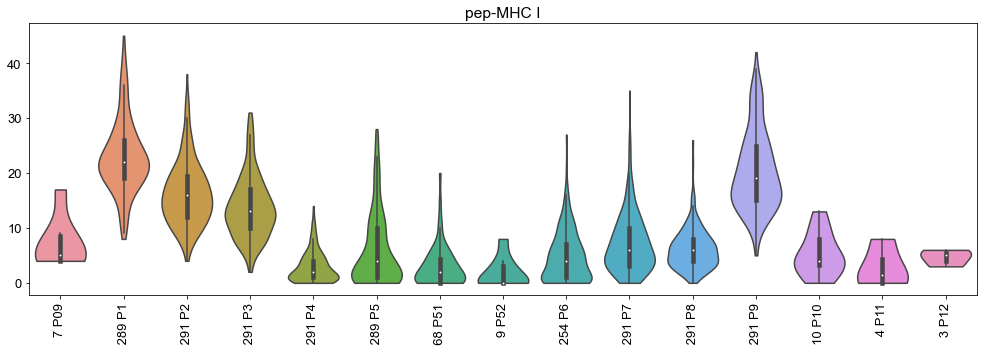

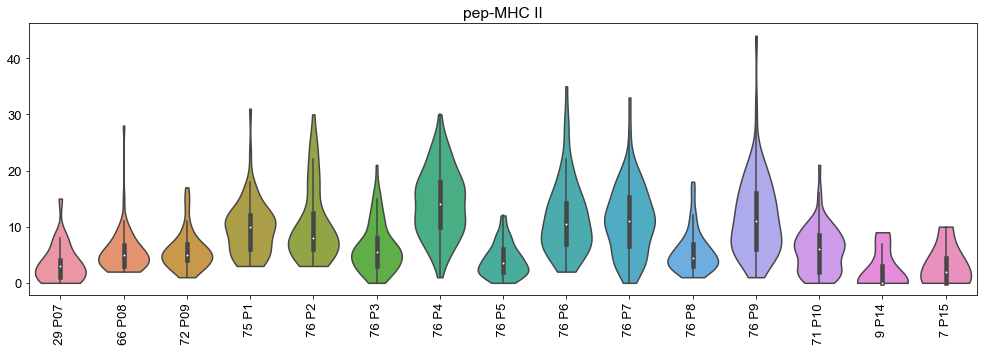

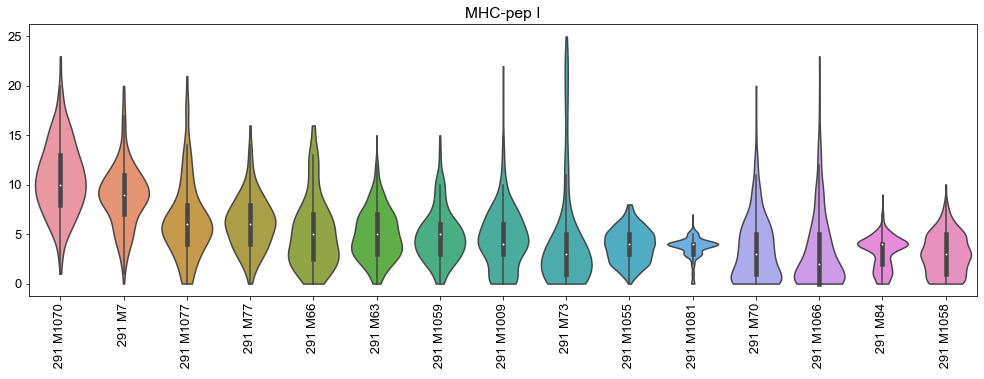

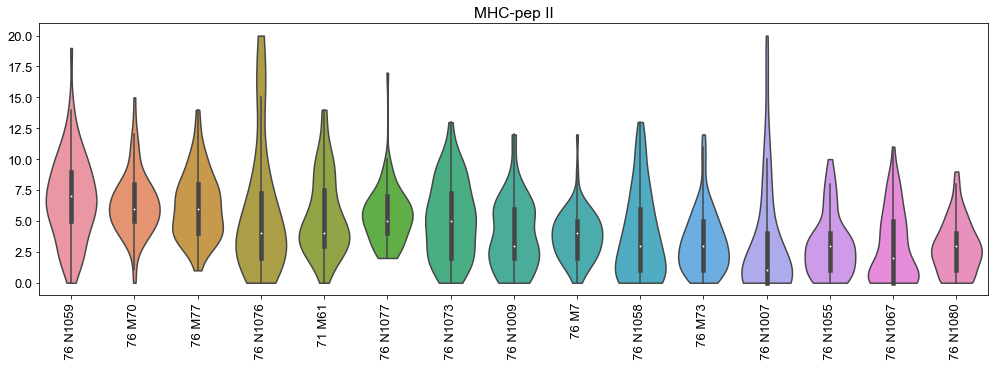

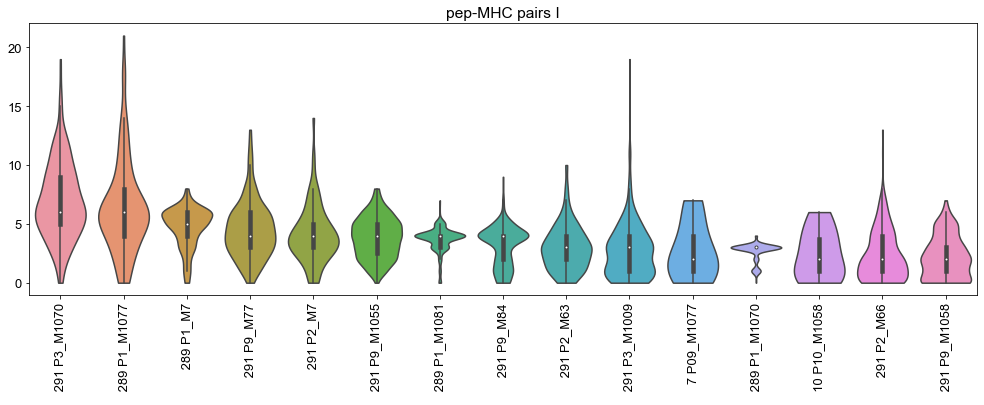

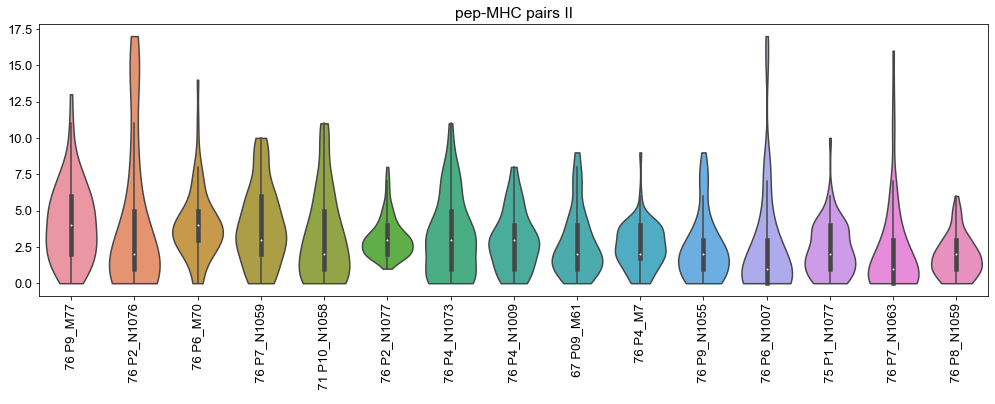

completed in   2.9 s


In [9]:
#plot pep-mhc contacts
t0=time.time()
with open(output_dir+'/contact_maps_pep-mhc.pckl','rb') as f:
    d=pickle.load(f)
res_contacts1,res_contacts2,pair_contacts=d['res_contacts1'],d['res_contacts2'],d['pair_contacts']
figsize=(17,5)
dict_to_violin(res_contacts1['I'],15,'pep-MHC I',sort_by_resname=True,figsize=figsize)
dict_to_violin(res_contacts1['II'],15,'pep-MHC II',sort_by_resname=True,figsize=figsize)
dict_to_violin(res_contacts2['I'],15,'MHC-pep I',sort_by_resname=False,figsize=figsize)
dict_to_violin(res_contacts2['II'],15,'MHC-pep II',sort_by_resname=False,figsize=figsize)
dict_to_violin(pair_contacts['I'],15,'pep-MHC pairs I',sort_by_resname=False,figsize=figsize)
dict_to_violin(pair_contacts['II'],15,'pep-MHC pairs II',sort_by_resname=False,figsize=figsize)
print('completed in {:5.1f} s'.format(time.time()-t0))      

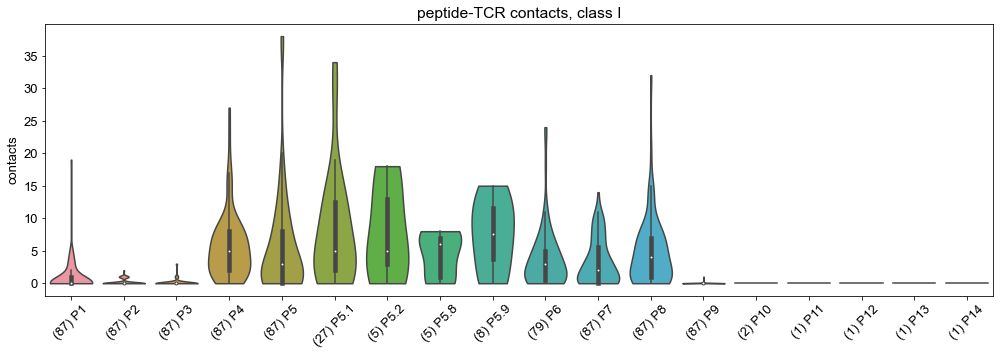

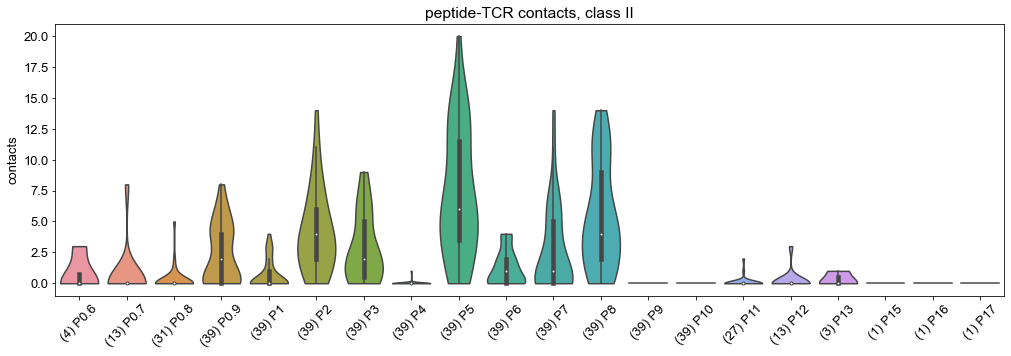

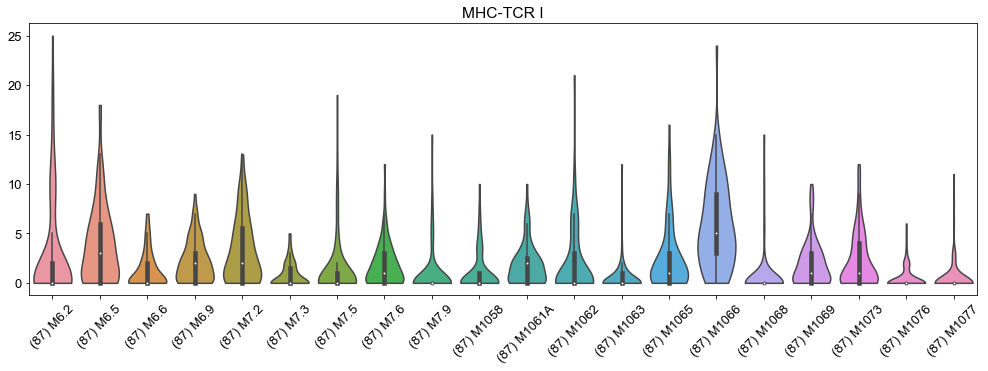

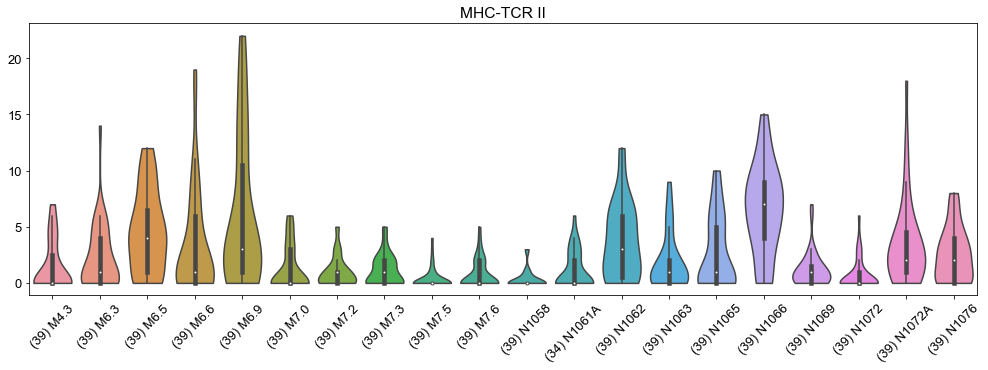

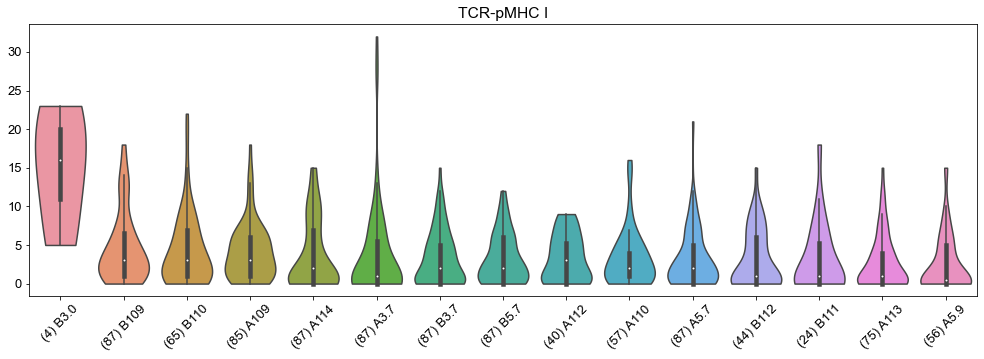

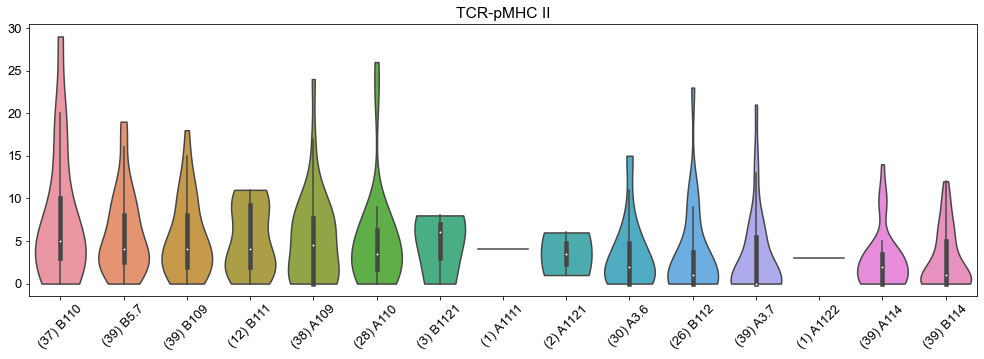

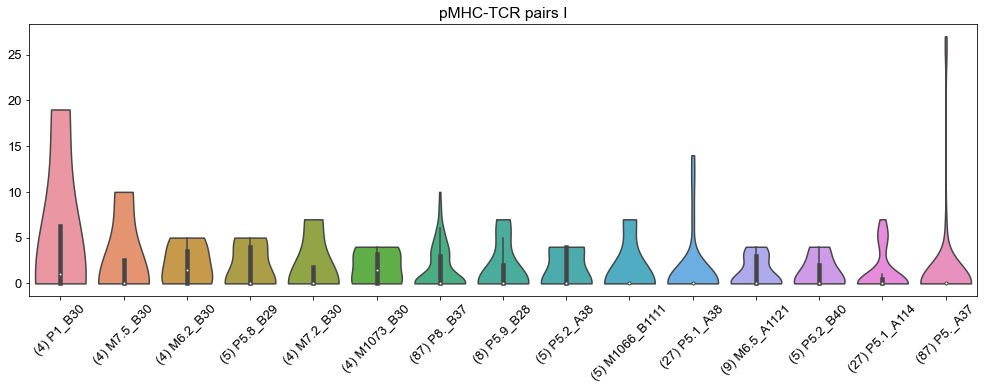

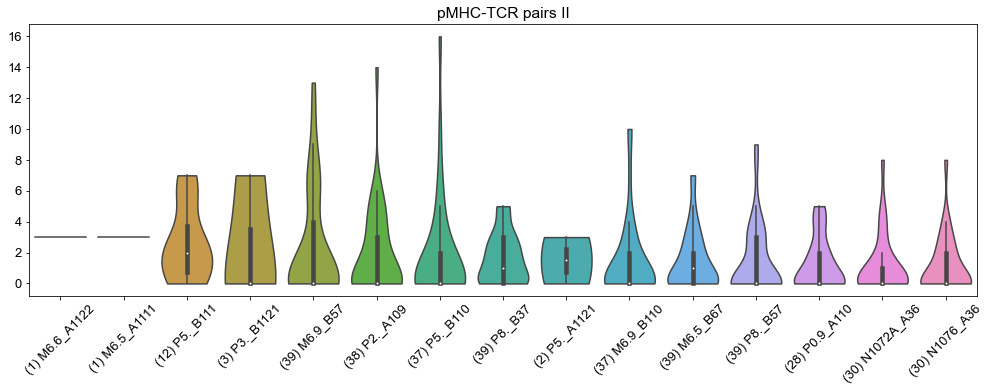

completed in   7.5 s


In [9]:
#plot pmhc-tcr contacts
t0=time.time()
with open(output_dir+'/contact_maps_pmhc-tcr.pckl','rb') as f:
    d=pickle.load(f)
res_contacts1,res_contacts2,pair_contacts=d['res_contacts1'],d['res_contacts2'],d['pair_contacts']
#split pep and mhc in res_contacts1
res_contacts1_split={'I':{},'II':{}}
rechain={'P':'P','M':'M','N':'M'}
for cl,v in res_contacts1.items():
    for k,w in v.items():
        res_contacts1_split[cl].setdefault(rechain[k[0]],{}).update({k:w})
figsize=(17,5)
save_to=fig_dir+'/contacts_pep_tcr_I.pdf'
dict_to_violin(res_contacts1_split['I']['P'],20,'peptide-TCR contacts, class I',ylabel='contacts',
               sort_by_resname=True,figsize=figsize,save_to=save_to)
save_to=fig_dir+'/contacts_pep_tcr_II.pdf'
dict_to_violin(res_contacts1_split['II']['P'],20,'peptide-TCR contacts, class II',ylabel='contacts',
               sort_by_resname=True,figsize=figsize,save_to=save_to)
dict_to_violin(res_contacts1_split['I']['M'],20,'MHC-TCR I',sort_by_resname=True,figsize=figsize)
dict_to_violin(res_contacts1_split['II']['M'],20,'MHC-TCR II',sort_by_resname=True,figsize=figsize)
dict_to_violin(res_contacts2['I'],15,'TCR-pMHC I',sort_by_resname=False,figsize=figsize)
dict_to_violin(res_contacts2['II'],15,'TCR-pMHC II',sort_by_resname=False,figsize=figsize)
dict_to_violin(pair_contacts['I'],15,'pMHC-TCR pairs I',sort_by_resname=False,figsize=figsize)
dict_to_violin(pair_contacts['II'],15,'pMHC-TCR pairs II',sort_by_resname=False,figsize=figsize)
print('completed in {:5.1f} s'.format(time.time()-t0))      

# peptide geometry

In [10]:
atom='CA' #CA or CB. Rerun the following cells to make plots
with open(output_dir+f'/peptide_coords_{atom}.pckl','rb') as f:
    pep_coords=pickle.load(f)
print(len(pep_coords))
print(pep_coords['1ao7_0'])
#collect coordinates
#exclude=('   53','   57') #too little data, causes sns.violin to show only boxplots
pep_coords_all={'I':{},'II':{}}
for c in pmhcs_clusters:
    pdb_id=c['pdbs'][0][0]
    if pdb_id in pmhc_pdbids: #restrict
        cl=pmhcs[c['pmhc_ids'][0]]['class']
        for res,xyz in pep_coords[pdb_id].items():
            if res>='   08' and res<='  12 ': # and res not in exclude: #cut the tails
            #if res>='   08' and res<='   5 ': #cut the tails
                pep_coords_all[cl].setdefault(res,[]).append(xyz)
#compute dispersions
for v in pep_coords_all.values():
    for k,w in v.items():
        w=np.array(w)
        v[k]=list(np.linalg.norm(w-np.average(w,axis=0),axis=1))   

1924
{'   1 ': array([-16.546,   2.083,   8.472], dtype=float32), '   2 ': array([-15.378,   5.487,   9.689], dtype=float32), '   3 ': array([-16.414,   7.299,  12.881], dtype=float32), '   4 ': array([-19.075,   9.949,  12.251], dtype=float32), '   5 ': array([-18.504,  12.668,  14.837], dtype=float32), '   6 ': array([-14.981,  14.24 ,  14.828], dtype=float32), '   7 ': array([-14.636,  17.502,  16.797], dtype=float32), '   8 ': array([-12.051,  20.31 ,  16.605], dtype=float32), '   9 ': array([-9.37 , 20.396, 19.375], dtype=float32)}


In [12]:
pep_coords_all['I']

{'   1 ': [0.33641827,
  0.11215132,
  0.39540586,
  0.33063275,
  0.27645752,
  0.16688916,
  0.25112247,
  0.6705614,
  0.32026353,
  0.19771484,
  0.73812836,
  0.33907655,
  0.24287736,
  0.4757795,
  0.11253087,
  0.42125088,
  0.50758284,
  0.18476401,
  0.0911541,
  0.5730141,
  0.26382,
  0.36825517,
  0.26068926,
  0.18953383,
  0.42515752,
  0.11837822,
  0.2752172,
  0.34995607,
  0.5746733,
  0.17410967,
  0.29023525,
  0.08957059,
  0.5471103,
  0.79155475,
  0.4780603,
  0.5499268,
  0.97267896,
  0.11463456,
  0.39724725,
  0.31014243,
  0.39856336,
  1.0346198,
  0.8666839,
  2.056088,
  0.111250065,
  0.54216886,
  0.6277054,
  0.3654197,
  0.33599535,
  0.26073045,
  0.23735143,
  0.499353,
  0.1766337,
  1.083878,
  1.7512039,
  0.13448505,
  0.2927288,
  0.22651537,
  0.1905142,
  0.40244946,
  0.8204312,
  0.5018666,
  0.21208072,
  0.13316736,
  0.246786,
  0.6627926,
  0.4121248,
  0.07420351,
  0.46023425,
  0.32335392,
  0.2944921,
  0.5309642,
  0.42789555,
  

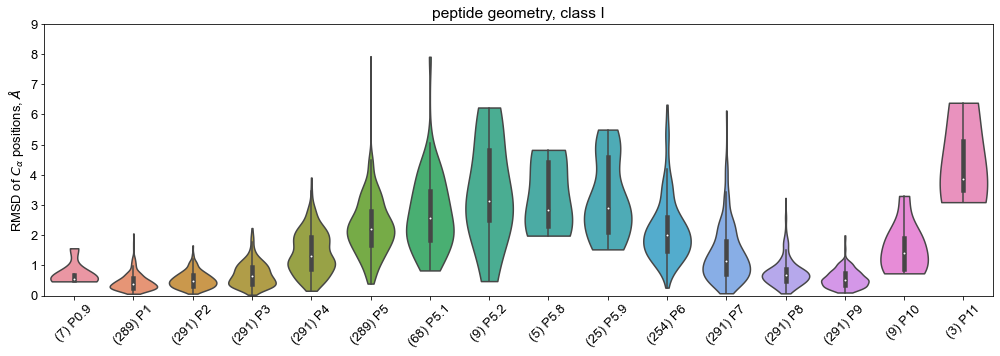

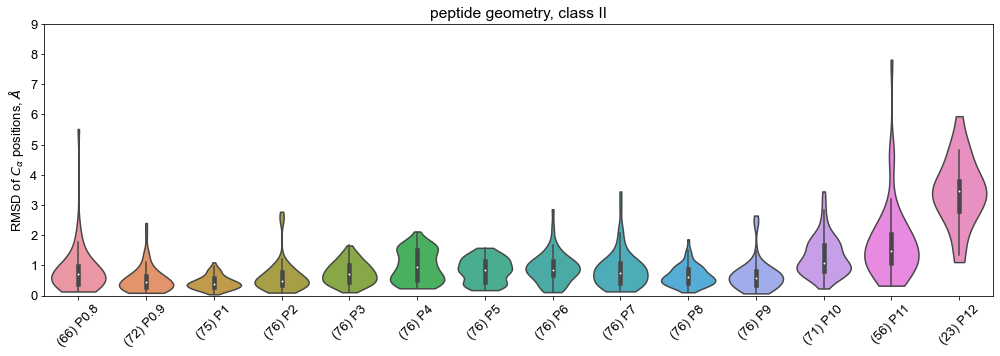

In [14]:
#CA
figsize=(17,5)
save_to=fig_dir+'/pep_geom_I.pdf'
ylabel=r'RMSD of $C_\alpha$ positions, $\AA$'
d={'P'+k:v for k,v in pep_coords_all['I'].items()}
dict_to_violin(d,100,'peptide geometry, class I',ylabel=ylabel,
               sort_by_resname=True,figsize=figsize,ylim=9,min_len=3,save_to=save_to)
d={'P'+k:v for k,v in pep_coords_all['II'].items()}
save_to=fig_dir+'/pep_geom_II.pdf'
dict_to_violin(d,100,'peptide geometry, class II',ylabel=ylabel,
               sort_by_resname=True,figsize=figsize,ylim=9,min_len=3,save_to=save_to)

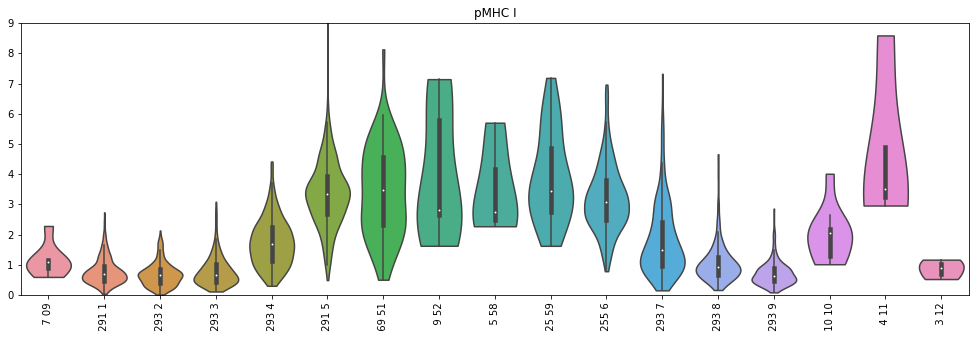

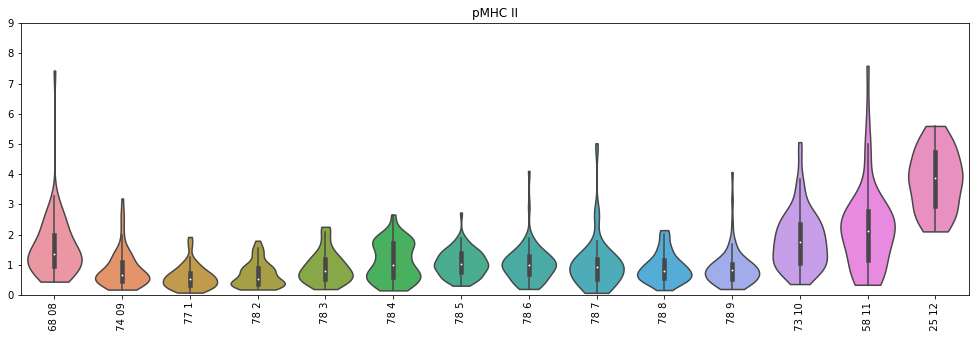

In [14]:
#CB
figsize=(17,5)
dict_to_violin(pep_coords_all['I'],100,'pMHC I',sort_by_resname=True,figsize=figsize,ylim=9,min_len=3)
dict_to_violin(pep_coords_all['II'],100,'pMHC II',sort_by_resname=True,figsize=figsize,ylim=9,min_len=3)